In [ ]:
Quantas retiradas de barra é bom
melhor seção

In [5]:
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=3000)
from math import sin, tan,  pi
from fconcrete.helpers import cond
import copy

In [6]:
material = fc.Material(E='27000 MPa', poisson=1, alpha=1)
section = fc.Rectangle(25,44.6)

#Design
f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0, length=20)
n2 = fc.Node.SimpleSupport(x=113, length=20)
n3 = fc.Node.SimpleSupport(x=583, length=20)
n4 = fc.Node.SimpleSupport(x=1188, length=20)

bar1 = fc.SingleBeamElement([n1, n2], section, material)
bar2 = fc.SingleBeamElement([n2, n3], section, material)
bar3 = fc.SingleBeamElement([n3, n4], section, material)

fc.config.available_material = {
    "concrete_long_steel_bars":fc.AvailableLongConcreteSteelBar(diameters=[8]),
    "concrete_transv_steel_bars":fc.AvailableTransvConcreteSteelBar(diameters=[8]),
}
    
beam = fc.Beam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 2,
)

self1 = copy.deepcopy(beam)

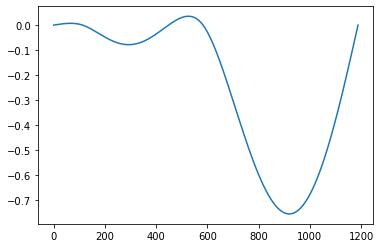

In [7]:
beam.plotDisplacementDiagram()